<a href="https://colab.research.google.com/github/Eroreis/bitirme/blob/main/Transform_Modeli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1174 - val_loss: 0.0095
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0219 - val_loss: 0.0088
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0138 - val_loss: 0.0099
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0112 - val_loss: 0.0073
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0105 - val_loss: 0.0072
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0090 - val_loss: 0.0052
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0094 - val_loss: 0.0067
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0079 - val_loss: 0.0080
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078 - val_loss: 0.0065
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0081 - val_loss: 0.0055
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0068 - val_loss: 0.0049
Epoch 12/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0073 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step

📊 Transformer Model Performansı (2024 Test Verisi)
MAE       = 6.28
RMSE      = 8.05
R²        = 0.7640
MAPE      = 18.47%
Doğruluk  ≈ 81.53%


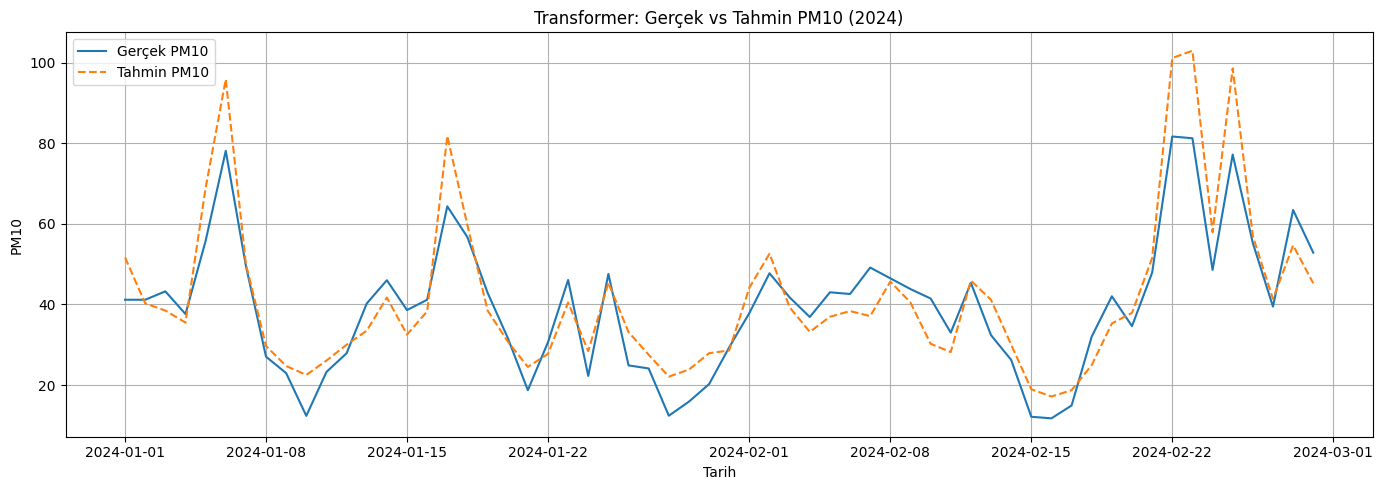

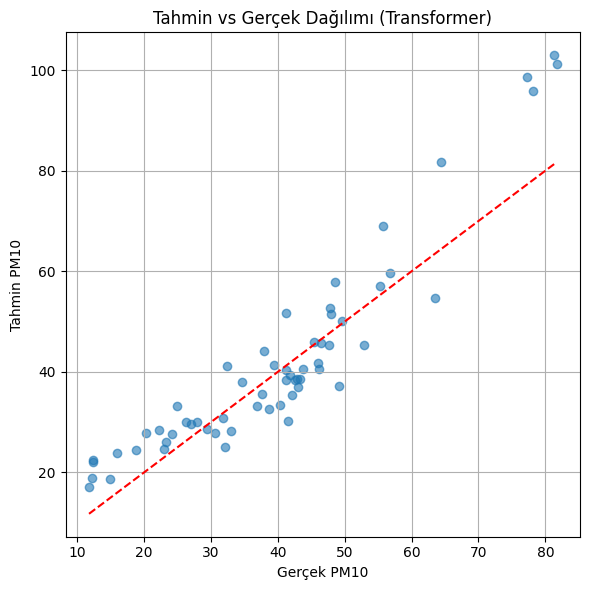

In [ ]:
# GEREKLİ KÜTÜPHANELER
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# VERİYİ YÜKLE
df = pd.read_csv("veri_knn_tamamlanmis_yuvarlanmis.csv")
df["Tarih"] = pd.to_datetime(df["Tarih"])

# GİRİŞ ÖZELLİKLERİ: ÖNCEKİ VE SONRAKİ GÜNLER
df["PM10_prev"] = df["PM10"].shift(1)
df["PM10_next"] = df["PM10"].shift(-1)

# TARİHSEL BİLGİLERİ EKLE
df["Ay"] = df["Tarih"].dt.month
df["Gun"] = df["Tarih"].dt.day

df = df.dropna().reset_index(drop=True)

# ÖZELLİKLER VE HEDEF
feature_columns = ["PM10_prev", "PM10_next", "SO2", "CO", "NO2", "NOX", "NO", "O3",
                   "Sıcaklık", "Nem", "Rüzgar Hızı", "Ay", "Gun"]
target_column = "PM10"

# VERİYİ AYIR
train = df[df["Tarih"] < "2024-01-01"]
test = df[df["Tarih"] >= "2024-01-01"].copy()

# ❗ Tahmin sırasında PM10_next bilinmeyeceği için test setinden çıkar
feature_columns_test = [col for col in feature_columns if col != "PM10_next"]

X_train = train[feature_columns].values
X_test = test[feature_columns_test].values
y_train = train[target_column].values
y_test = test[target_column].values

# NORMALİZASYON
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(np.hstack([
    test[["PM10_prev"]].values,  # boşluk doldurulacak
    np.zeros((len(test), 1)),   # PM10_next bilinmiyor → 0 koy
    test[["SO2", "CO", "NO2", "NOX", "NO", "O3", "Sıcaklık", "Nem", "Rüzgar Hızı", "Ay", "Gun"]].values
]))

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# TRANSFORMER BLOĞU
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Add()([x, inputs])
    x = LayerNormalization()(x)

    x_ff = Dense(ff_dim, activation="relu")(x)
    x_ff = Dropout(dropout)(x_ff)
    x_ff = Dense(inputs.shape[-1])(x_ff)
    x = Add()([x, x_ff])
    x = LayerNormalization()(x)
    return x

# MODEL OLUŞTUR
def build_model(input_shape):
    inputs = Input(shape=input_shape)
    x = transformer_encoder(inputs, head_size=64, num_heads=2, ff_dim=128, dropout=0.1)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = Dropout(0.1)(x)
    x = Dense(32, activation="relu")(x)
    outputs = Dense(1)(x)
    return Model(inputs, outputs)

# MODELİ DERLE
model = build_model(X_train_scaled.shape[1:])
model.compile(optimizer=Adam(0.001), loss="mse")
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# EĞİTİM
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# TAHMİN
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_inv = scaler_y.inverse_transform(y_test_scaled)

# METRİKLER
mae = mean_absolute_error(y_test_inv, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred))
r2 = r2_score(y_test_inv, y_pred)
mape = np.mean(np.abs((y_test_inv - y_pred) / y_test_inv)) * 100
accuracy = 100 - mape

print("\n📊 Transformer Model Performansı (2024 Test Verisi)")
print(f"MAE       = {mae:.2f}")
print(f"RMSE      = {rmse:.2f}")
print(f"R²        = {r2:.4f}")
print(f"MAPE      = {mape:.2f}%")
print(f"Doğruluk  ≈ {accuracy:.2f}%")

# GRAFİKLER
df_results = pd.DataFrame({
    "Tarih": test["Tarih"].reset_index(drop=True),
    "Gerçek PM10": y_test_inv.flatten(),
    "Tahmin PM10": y_pred.flatten()
})

plt.figure(figsize=(14, 5))
plt.plot(df_results["Tarih"], df_results["Gerçek PM10"], label="Gerçek PM10")
plt.plot(df_results["Tarih"], df_results["Tahmin PM10"], label="Tahmin PM10", linestyle="--")
plt.title("Transformer: Gerçek vs Tahmin PM10 (2024)")
plt.xlabel("Tarih")
plt.ylabel("PM10")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(df_results["Gerçek PM10"], df_results["Tahmin PM10"], alpha=0.6)
plt.plot([df_results["Gerçek PM10"].min(), df_results["Gerçek PM10"].max()],
         [df_results["Gerçek PM10"].min(), df_results["Gerçek PM10"].max()], 'r--')
plt.title("Tahmin vs Gerçek Dağılımı (Transformer)")
plt.xlabel("Gerçek PM10")
plt.ylabel("Tahmin PM10")
plt.grid(True)
plt.tight_layout()
plt.show()


100%|██████████| 730/730 [00:48<00:00, 15.03it/s]


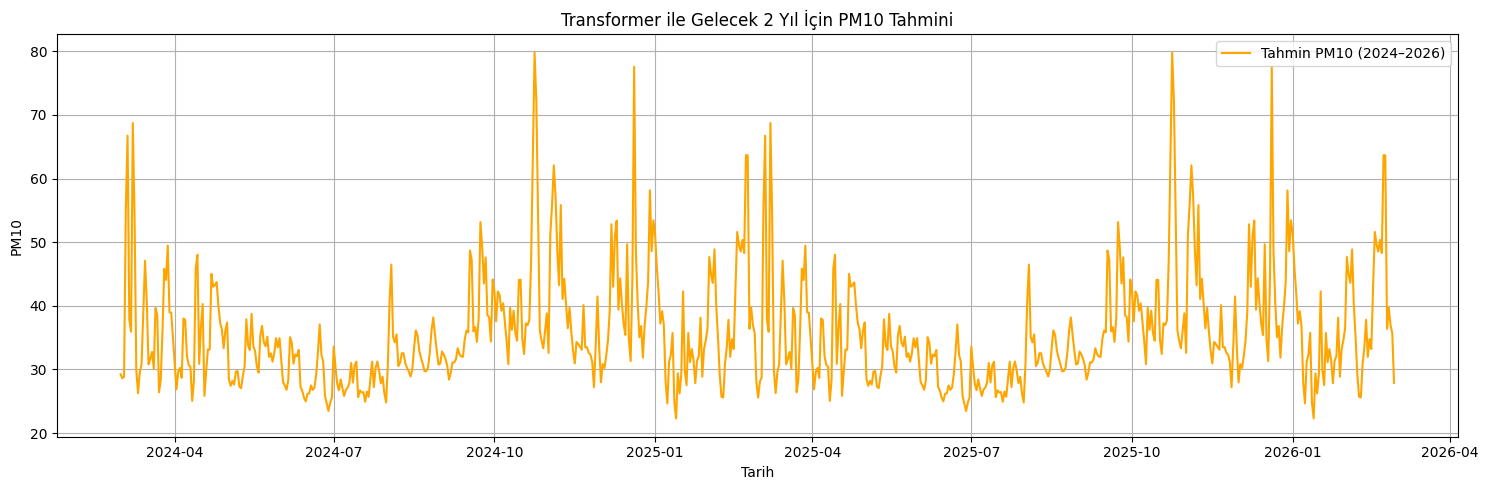


📌 Tahmin Özeti (2024–2026):
count    730.000000
mean      35.782608
std        8.860295
min       22.312246
25%       30.114151
50%       33.425041
75%       38.975636
max       79.769424
Name: Tahmin PM10, dtype: float64


In [ ]:
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')

# Tarihsel ortalama oluştur: Ay ve gün bazlı meteorolojik ortalama
df["Ay"] = df["Tarih"].dt.month
df["Gun"] = df["Tarih"].dt.day

mean_features_by_day = df.groupby(["Ay", "Gun"])[["SO2", "CO", "NO2", "NOX", "NO", "O3", "Sıcaklık", "Nem", "Rüzgar Hızı"]].mean()

# Son veri noktası üzerinden başla
last_input_row = df.iloc[-1]
pm10_prev = last_input_row["PM10"]
last_date = last_input_row["Tarih"]

# 730 gün (2 yıl) tahmin üret
future_days = 730
future_predictions = []
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days)

for date in tqdm(future_dates):
    ay = date.month
    gun = date.day

    # Giriş verisi hazırla
    try:
        others = mean_features_by_day.loc[(ay, gun)].values
    except KeyError:
        others = mean_features_by_day.mean().values

    pm10_next = 0

    # Modelin beklediği 13 özellik: [PM10_prev, PM10_next, 9 değer, Ay, Gun]
    input_features = np.concatenate([[pm10_prev, pm10_next], others, [ay, gun]]).reshape(1, -1)
    input_scaled = scaler_X.transform(input_features).reshape(1, 1, -1)

    pred_scaled = model.predict(input_scaled, verbose=0)
    pred_real = scaler_y.inverse_transform(pred_scaled)[0, 0]
    future_predictions.append(pred_real)

    pm10_prev = pred_real

# Sonuçları DataFrame'e aktar
df_future = pd.DataFrame({
    "Tarih": future_dates,
    "Tahmin PM10": future_predictions
})

# CSV olarak kaydet
df_future.to_csv("tahmin_2024_2026_transformer.csv", index=False)

# Grafik
plt.figure(figsize=(15, 5))
plt.plot(df_future["Tarih"], df_future["Tahmin PM10"], label="Tahmin PM10 (2024–2026)", color="orange")
plt.title("Transformer ile Gelecek 2 Yıl İçin PM10 Tahmini")
plt.xlabel("Tarih")
plt.ylabel("PM10")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Özet istatistik
print("\n📌 Tahmin Özeti (2024–2026):")
print(df_future["Tahmin PM10"].describe())


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1292 - val_loss: 0.0101
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0196 - val_loss: 0.0069
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0167 - val_loss: 0.0059
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0100 - val_loss: 0.0048
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0101 - val_loss: 0.0040
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0072 - val_loss: 0.0035
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057 - val_loss: 0.0028
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0053 - val_loss: 0.0035
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0044 - val_loss: 0.0034
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - val_loss: 0.0017
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - val_loss: 0.0012
Epoch 12/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step

📊 Transformer Model Performansı (2024 Test Verisi)
MAE       = 1.74
RMSE      = 2.25
R²        = 0.9814
MAPE      = 5.86%
Doğruluk  ≈ 94.14%


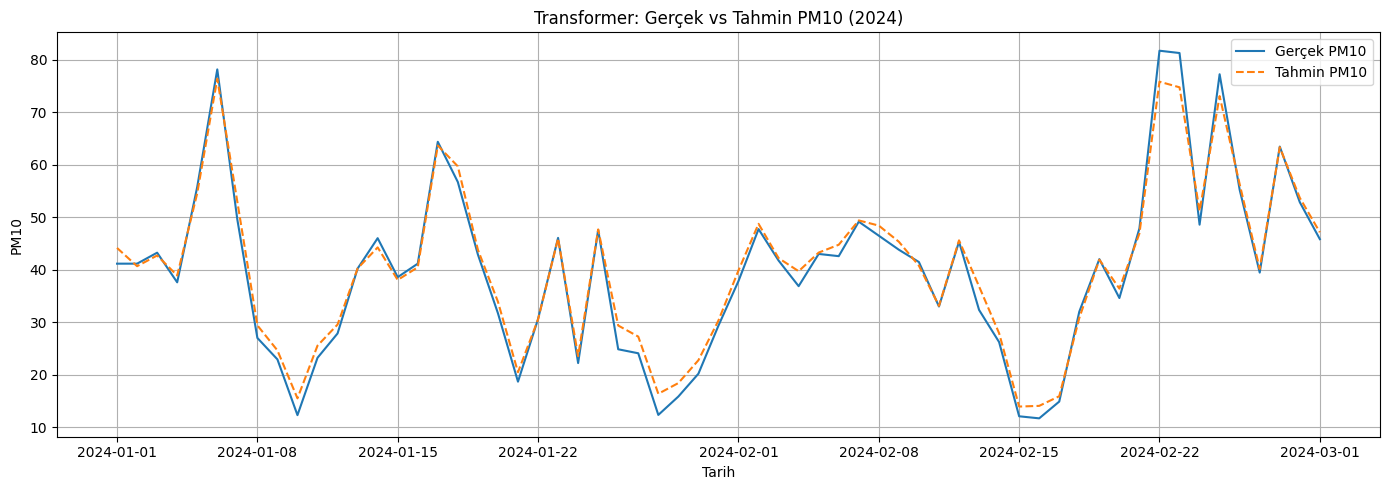

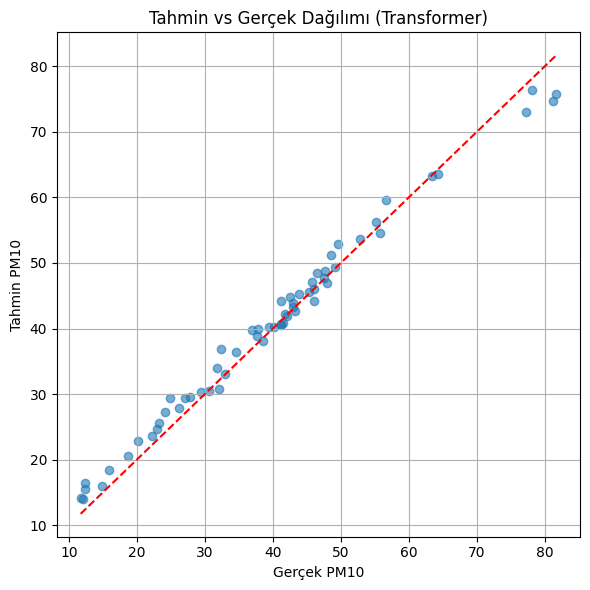

100%|██████████| 730/730 [00:49<00:00, 14.68it/s]


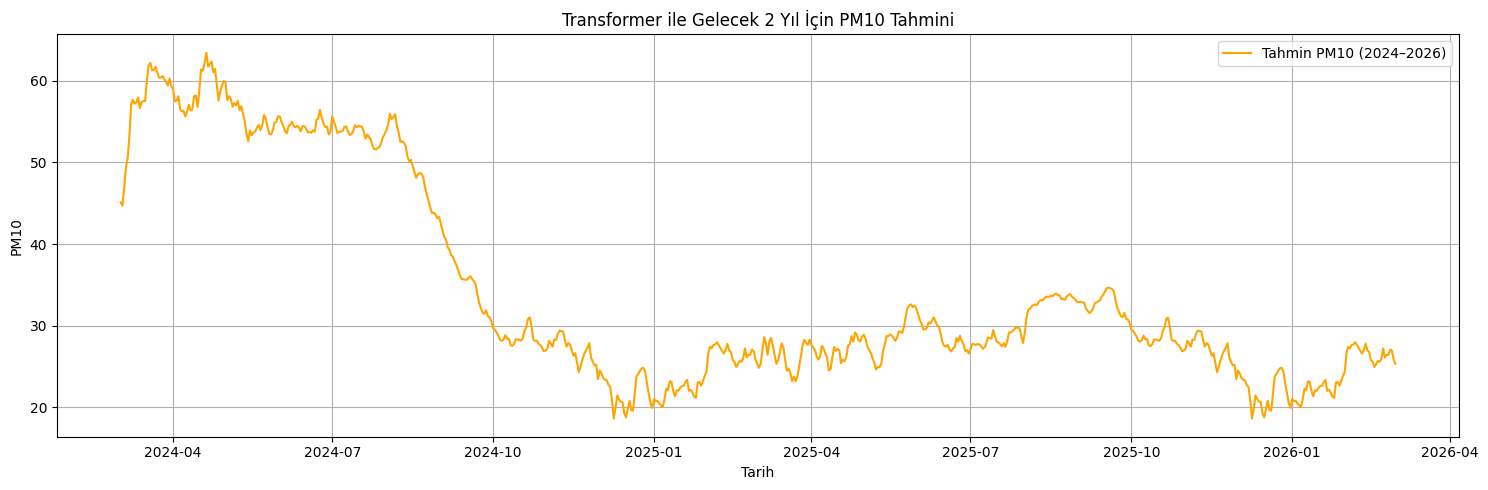


📌 Tahmin Özeti (2024–2026):
count    730.000000
mean      34.232586
std       12.603165
min       18.632143
25%       26.014932
50%       28.317712
75%       43.029603
max       63.434246
Name: Tahmin PM10, dtype: float64


In [ ]:
# GEREKLİ KÜTÜPHANELER
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')

# VERİYİ YÜKLE
df = pd.read_csv("veri_knn_tamamlanmis_yuvarlanmis.csv")
df["Tarih"] = pd.to_datetime(df["Tarih"])
df["PM10_prev"] = df["PM10"].shift(1)
df = df.dropna().reset_index(drop=True)

# ÖZELLİK VE HEDEF
feature_columns = ["PM10_prev", "PM10", "SO2", "CO", "NO2", "NOX", "NO", "O3", "Sıcaklık", "Nem", "Rüzgar Hızı"]
target_column = "PM10"

# EĞİTİM VE TEST AYIRIMI
train = df[df["Tarih"] < "2024-01-01"]
test = df[df["Tarih"] >= "2024-01-01"]

X_train = train[feature_columns].values
y_train = train[target_column].values
X_test = test[feature_columns].values
y_test = test[target_column].values

# NORMALİZASYON
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# TRANSFORMER BLOĞU
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Add()([x, inputs])
    x = LayerNormalization()(x)

    x_ff = Dense(ff_dim, activation="relu")(x)
    x_ff = Dropout(dropout)(x_ff)
    x_ff = Dense(inputs.shape[-1])(x_ff)
    x = Add()([x, x_ff])
    x = LayerNormalization()(x)
    return x

# MODEL OLUŞTUR
def build_model(input_shape):
    inputs = Input(shape=input_shape)
    x = transformer_encoder(inputs, head_size=64, num_heads=2, ff_dim=128, dropout=0.1)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = Dropout(0.1)(x)
    x = Dense(32, activation="relu")(x)
    outputs = Dense(1)(x)
    return Model(inputs, outputs)

# MODELİ DERLE
model = build_model(X_train_scaled.shape[1:])
model.compile(optimizer=Adam(0.001), loss="mse")
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# EĞİTİM
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# TAHMİN
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_inv = scaler_y.inverse_transform(y_test_scaled)

# METRİKLER
mae = mean_absolute_error(y_test_inv, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred))
r2 = r2_score(y_test_inv, y_pred)
mape = np.mean(np.abs((y_test_inv - y_pred) / y_test_inv)) * 100
accuracy = 100 - mape

print("\n📊 Transformer Model Performansı (2024 Test Verisi)")
print(f"MAE       = {mae:.2f}")
print(f"RMSE      = {rmse:.2f}")
print(f"R²        = {r2:.4f}")
print(f"MAPE      = {mape:.2f}%")
print(f"Doğruluk  ≈ {accuracy:.2f}%")

# TAHMİN GRAFİĞİ
df_results = pd.DataFrame({
    "Tarih": test["Tarih"].reset_index(drop=True),
    "Gerçek PM10": y_test_inv.flatten(),
    "Tahmin PM10": y_pred.flatten()
})

plt.figure(figsize=(14, 5))
plt.plot(df_results["Tarih"], df_results["Gerçek PM10"], label="Gerçek PM10")
plt.plot(df_results["Tarih"], df_results["Tahmin PM10"], label="Tahmin PM10", linestyle="--")
plt.title("Transformer: Gerçek vs Tahmin PM10 (2024)")
plt.xlabel("Tarih")
plt.ylabel("PM10")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(df_results["Gerçek PM10"], df_results["Tahmin PM10"], alpha=0.6)
plt.plot([df_results["Gerçek PM10"].min(), df_results["Gerçek PM10"].max()],
         [df_results["Gerçek PM10"].min(), df_results["Gerçek PM10"].max()], 'r--')
plt.title("Tahmin vs Gerçek Dağılımı (Transformer)")
plt.xlabel("Gerçek PM10")
plt.ylabel("Tahmin PM10")
plt.grid(True)
plt.tight_layout()
plt.show()

# GELECEK 2 YILLIK TAHMİN

# Tarihsel ortalama oluştur: Ay ve gün bazlı meteorolojik ortalama
df["Ay"] = df["Tarih"].dt.month
df["Gun"] = df["Tarih"].dt.day
mean_features_by_day = df.groupby(["Ay", "Gun"])[["SO2", "CO", "NO2", "NOX", "NO", "O3", "Sıcaklık", "Nem", "Rüzgar Hızı"]].mean()

# Son veri noktası üzerinden başla
last_input_row = df.iloc[-1]
pm10_prev = last_input_row["PM10"]
pm10 = last_input_row["PM10"]
last_date = last_input_row["Tarih"]

future_days = 730
future_predictions = []
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days)

for date in tqdm(future_dates):
    ay = date.month
    gun = date.day

    try:
        others = mean_features_by_day.loc[(ay, gun)].values
    except KeyError:
        others = mean_features_by_day.mean().values

    input_row = np.concatenate([[pm10_prev, pm10], others]).reshape(1, -1)
    input_scaled = scaler_X.transform(input_row).reshape(1, 1, -1)

    pred_scaled = model.predict(input_scaled, verbose=0)
    pred_real = scaler_y.inverse_transform(pred_scaled)[0, 0]
    future_predictions.append(pred_real)

    pm10_prev = pm10
    pm10 = pred_real

# Sonuçları DataFrame'e aktar
df_future = pd.DataFrame({
    "Tarih": future_dates,
    "Tahmin PM10": future_predictions
})

df_future.to_csv("tahmin_2024_2026_transformer.csv", index=False)

# Grafik
plt.figure(figsize=(15, 5))
plt.plot(df_future["Tarih"], df_future["Tahmin PM10"], label="Tahmin PM10 (2024–2026)", color="orange")
plt.title("Transformer ile Gelecek 2 Yıl İçin PM10 Tahmini")
plt.xlabel("Tarih")
plt.ylabel("PM10")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Özet istatistik
print("\n📌 Tahmin Özeti (2024–2026):")
print(df_future["Tahmin PM10"].describe())
